# Analysis of Austin Animal Center Shelter Outcome dataset
Trying to model the outcomes of animals at the Austin Animal Center Shelter, using the [Austin Animal Center Shelter Income and Outcome dataset (Kaggle).](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes) <br>

Dar Mendelowitz 316491208

## Imports

In [79]:
# Data processing
import pandas as pd
import numpy as np

# Statistics
from scipy.stats import chi2_contingency

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Helper functions
from utils import convert_to_years, print_animal_count, sort_colors
from missing_values import print_animal_ids, get_missing_animal_ids, get_existing_animal_ids_in_dataset
from missing_values import filter_null_values, update_column

import warnings
warnings.filterwarnings("ignore")

## Loading the Austin Animal Center Shelter Outcome dataset

In [2]:
# Loading the CSV dataset
df_in_out = pd.read_csv("./data/aac_intakes_outcomes.csv")
df_in = pd.read_csv("./data/aac_intakes.csv")
df_out = pd.read_csv("./data/aac_outcomes.csv")
dtf = df_out

# Defining the columns
cols = ["age_upon_outcome", "animal_id", "animal_type", "breed", "color", "date_of_birth", "datetime", "monthyear",
        "name", "outcome_subtype", "outcome_type", "sex_upon_outcome"]
dtf = dtf[cols]

In [3]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
dtf.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,80673,80681,80681,80681,80681,80681,80681,80681,56116,36893,80667,80679
unique,46,72877,5,2176,532,5956,66474,66474,14824,19,9,5
top,1 year,A721033,Dog,Domestic Shorthair Mix,Black/White,2015-09-01T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14911,13,45856,23821,8396,112,39,39,362,20082,34232,28702


In the table above, the number of animals in the shelter is 80681 (the count of unique 'animal_id' entries). However, not all columns contain 80681 values, as some entries are missing (NaN values).

For instance:

* The column 'age_upon_outcome' contains slightly fewer values, specifically 80673 entries.
* The 'name' column has significantly fewer entries, totaling 56116.
* In the 'outcome_subtype' column, there are even fewer entries, with only 36893 values present, which is less than half of the total number of animals in the shelter.
* Additionally, both the 'outcome_type' and 'sex_upon_outcome' columns have fewer entries.

Moreover, the number of unique 'animal_id' entries is less than the overall number of 'animal_id' entries (72877 < 80681). This discrepancy occurs because some animals have returned to the shelter. For example, a cat named Elsa (animal_id: A684460) was initially adopted (first outcome) at the age of 2 months. However, she was later returned to the shelter (sadly, her owner surrendered her at the age of 1 year, according to the aac_intakes_outcomes.csv table). After 25 days, Elsa was transferred to another shelter (second outcome).

***

### A first examination of the target feature - 'outcome_type':

A histogram of the target feature 'outcome_type':

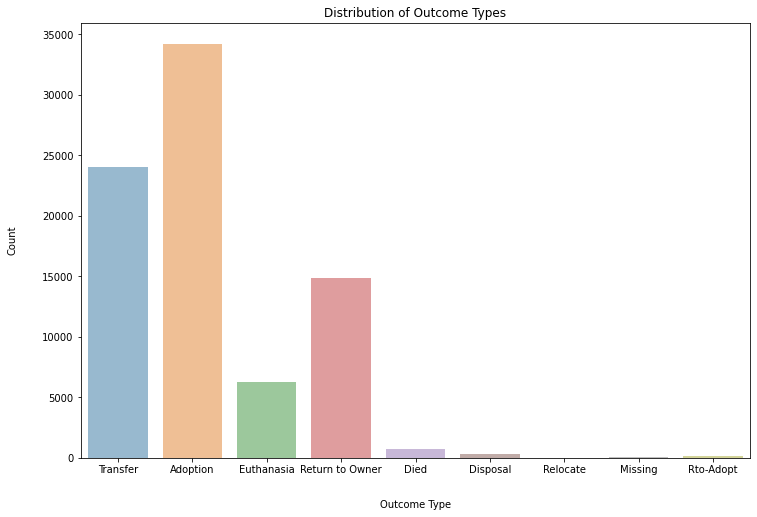

In [5]:
plt.figure(figsize=(12, 8))
sns.countplot(data=dtf, x='outcome_type', alpha=0.5)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type', labelpad=25)
plt.ylabel('Count', labelpad=25)
plt.show()

We can see that most animals were adopted (almost 35,000 animals). Almost 25,000 animals were transfered (to another shelter), about 15,000 were returned to their original owners, a little bit more than 5000 were euthanized. A small number of animals have died, an even smaller number were disposed, relocated, missing or Rto-Adopted.

Overall, most animals either were adopted, transfered, returned to owner or euthanized.

In [6]:
outcome_list = ['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died', 'Rto-Adopt', 'Missing', 'Disposal',
                'Relocate']

***

## Viewing the Baseline Model

***The basic model will later be compared to the final model.***

### Training the basic model and predicting

In [7]:
# Initialize the label encoder
encoder = LabelEncoder()

In [16]:
# Drop 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# List of categorical columns to encode
categorical_columns = ['breed', 'color', 'name', 'outcome_subtype', 'sex_upon_outcome', 'outcome_type', 'animal_type']

# Encode categorical columns
for column in categorical_columns:
    dtf_model[column] = encoder.fit_transform(dtf_model[column])

In [17]:
# Separate features and target variable
X = dtf_model.drop('outcome_type', axis=1)  # Features
y = dtf_model['outcome_type']  # Target variable

# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Initialize the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [19]:
# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [20]:
# Predict on the test data
y_pred = model.predict(X_test)

### Evaluating the model

In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.23%


In [22]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.87991077 0.88249876 0.85647    0.88063956 0.89762023 0.90195835
 0.90307387 0.89638076 0.89786812 0.90183441]
Mean cross-validation score: 0.8898254844971539


Note that the mean cross-validation score in 88.98%, which is close to the accuracy that was calculated (89.23%).
The model utilized a basic LabelEncoder to encode categorical data, and since the data has a lot of null values and was barely proccessed, then there might be some improvement in accuracy in future predictions.

**This finishes the basic introduction and basic analyses.**

***

## Data Pre-Processing

***Data cleansing and additional feature engineering.***

### Missing values

How many values are missing?

In [8]:
dtf.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                24565
outcome_subtype     43788
outcome_type           14
sex_upon_outcome        2
dtype: int64

There are 8 missing values in the 'age_upon_outcome' column, 14 in the 'outcome_type' column, and 2 in the 'sex_upon_outcome' column, all of which can be addressed relatively easily (for instance, some missing data may be found in the 'in_out_df' dataset). However, the primary challenge lies in managing the extensive amount of missing data in the 'name' and 'outcome_subtype' columns.

Some missing values could potentially be recovered from the aac_intakes_outcomes.csv dataset and the aac_intakes.csv dataset. While columns such as 'age_upon_outcome', 'outcome_type', and 'sex_upon_outcome' contain only a few missing values, it is worth searching for any existing missing data that might be present in the other datasets (besides searching for missing data of the two major sparse columns - 'name' and 'outcome_subtype').

***

#### Missing values of 'age_upon_outcome'

In [9]:
column_name = 'age_upon_outcome'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [10]:
# Find all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_age)

# Selecting the existing 'animal_id' values from missing_animal_ids_age based on existence in the filtered df_in_out
existing_animal_id_age = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_age, df_id)
print_animal_ids(column_name, existing_animal_id_age, 'df_in_out')

Animal IDs with missing values in 'age_upon_outcome' column:
71248    A737705
80344    A768766
80541    A768782
80544    A769181
80548    A769209
80608    A769277
80628    A768281
80664    A769101
Name: animal_id, dtype: object

Animal IDs with missing values in 'age_upon_outcome' column that exist in df_in_out dataset:
80541    A768782
Name: animal_id, dtype: object


Retrieving the missing value, updating the 'age_upon_outcome' column with the new value, and filtering out any rows with missing values in the 'age_upon_outcome' column, which are also absent in the df_in_out dataset:

In [11]:
# Retrieving the missing value and updating the 'age_upon_outcome' column with the new value
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_age, df_id)

# Geting all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)

# Filtering dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_age)]

***

#### Missing values of 'outcome_type'

In [12]:
column_name = 'outcome_type'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [13]:
# Find all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome based on existence in the filtered df_in_out
existing_animal_id_outcome = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_outcome, df_id)

# Filtering out any null values
existing_animal_id_outcome = filter_null_values(df_in_out, column_name, existing_animal_id_outcome, outcome_list, df_id)

print_animal_ids(column_name, existing_animal_id_outcome, 'df_in_out')

Animal IDs with missing values in 'outcome_type' column:
8056     A671017
9951     A674209
9975     A679066
12758    A686025
30969    A744013
55432    A718046
64762    A737930
67535    A755711
72899    A755715
75152    A755716
80590    A769260
80598    A769266
Name: animal_id, dtype: object

Animal IDs with missing values in 'outcome_type' column that exist in df_in_out dataset:
64762    A737930
67535    A755711
72899    A755715
75152    A755716
Name: animal_id, dtype: object


Retrieving the missing values, updating the 'outcome_type' column with the new values, and filtering out any rows with missing values in the 'outcome_type' column, which are also absent in the df_in_out dataset:

In [14]:
# Retrieving the missing values and updating the 'outcome_type' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_outcome, df_id)

# Get all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)

# Filter dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_outcome)]

***

#### Missing values of 'sex_upon_outcome'

--------------------maybe just delete in the first place... there aren't many samples missing

In [15]:
column_name = 'sex_upon_outcome'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [16]:
# Find all 'animal_id' of rows with None values in the 'sex_upon_outcome' column
missing_animal_ids_outcome_sex = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome_sex)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome_sex
# based on existence in the filtered df_in_out
existing_animal_id_outcome_sex = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                    missing_animal_ids_outcome_sex, df_id)
print_animal_ids(column_name, existing_animal_id_outcome_sex, 'df_in_out')

Animal IDs with missing values in 'sex_upon_outcome' column:
12248    A667395
Name: animal_id, dtype: object

Animal IDs with missing values in 'sex_upon_outcome' column that exist in df_in_out dataset:
Series([], Name: animal_id, dtype: object)


There is no existing data in df_in_out dataset (that matches the missing value in the 'sex_upon_outcome' column). The missing row will just be deleted from the dtf dataset.

Filtering out the row with the missing value in the 'sex_upon_outcome' column, which are also absent in the df_in_out dataset:

In [17]:
# Finding the 'animal_id' that doesn't exist in df_in_out
missing_animal_id_outcome_sex = missing_animal_ids_outcome_sex.iloc[0]

# Filter dtf to exclude the row with the 'animal_id' value of missing_animal_id_outcome_sex
dtf = dtf.drop(dtf[dtf['animal_id'] == missing_animal_id_outcome_sex].index)

***

#### Missing values of 'outcome_subtype'

In [18]:
column_name = 'outcome_subtype'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

-----------------Takes ~50s - add skip option

In [19]:
sub_outcome_list = dtf['outcome_subtype'].dropna().unique()

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_sub)

# Selecting the existing 'animal_id' values from missing_animal_ids_sub based on existence in the filtered df_in_out
existing_animal_id_sub = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_sub, df_id)

# Filtering out any null values
existing_animal_id_sub = filter_null_values(df_in_out, column_name, existing_animal_id_sub, sub_outcome_list, df_id)

print_animal_ids(column_name, existing_animal_id_sub, 'df_in_out')

Animal IDs with missing values in 'outcome_subtype' column:
2        A675708
6        A685067
8        A675405
11       A640655
15       A684460
          ...   
80676    A769131
80677    A665594
80678    A769120
80679    A764644
80680    A768726
Name: animal_id, Length: 43777, dtype: object

Animal IDs with missing values in 'outcome_subtype' column that exist in df_in_out dataset:
15       A684460
29       A665344
84       A675373
91       A681449
224      A685958
          ...   
79964    A767718
79967    A767718
80199    A763701
80367    A768895
80418    A767357
Name: animal_id, Length: 1842, dtype: object


Retrieving the missing values, updating the 'outcome_subtype' column with the new values, and filtering the rows with missing values in the 'outcome_type' column, which are also absent in the df_in_out dataset (no deletion) while defining a default outcome subtype:

---------------------Takes ~1-2minutes - add skip option

In [20]:
# Retrieving the missing values and updating the 'outcome_subtype' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_sub, df_id)

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)

# Define a default value for missing values in 'outcome_subtype' column
default_subtype = "Unknown"

# Set the default value for 'outcome_subtype' where 'animal_id' matches any element in missing_animal_ids_sub
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_sub), column_name] = default_subtype

I refrained from simply duplicating the values from the 'outcome_type' column and substituting them with missing values in the 'outcome_subtype' column, respectively. My rationale behind this decision was to avoid artificially inflating the importance of those instances. By replicating the same value twice within a single row for certain entries in the dataset, it could potentially skew the significance of those instances compared to others. I opted to assign a default value of 'Unknown' instead.

***

#### Missing values of 'name'

In [21]:
column_name = 'name'
df_id = 'animal_id'

Checking if the missing 'animal_id' values exist in df_in (using the aac_intakes.csv dataset):

In [22]:
# Find all 'animal_id' of rows with None values in the 'name' column
missing_animal_ids_name = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_name)

# Selecting the existing 'animal_id' values from missing_animal_ids_name based on existence in the filtered df_in
existing_animal_id_name = get_existing_animal_ids_in_dataset(df_in, column_name, missing_animal_ids_name, df_id)
print_animal_ids(column_name, existing_animal_id_name, 'df_in')

Animal IDs with missing values in 'name' column:
0        A684346
4        A683115
14       A670420
16       A673952
19       A669621
          ...   
80661    A769130
80662    A769322
80665    A769321
80669    A769320
80673    A769127
Name: animal_id, Length: 24553, dtype: object

Animal IDs with missing values in 'name' column that exist in df_in dataset:
Series([], Name: animal_id, dtype: object)


There is no existing data in df_in dataset (that matches the missing values in the 'name' column).

Animals without a name will be given a default name. The reason that I chose to give them a default name (rather than just deleting the rows with the missing values) is that there might be a reason why these animals weren't given a name, and the fact that they don't have a name might predict their outcome. For example, rabid animals that are being euthanized aren't being named.

Missing values in the df_in dataset:

In [23]:
df_in['name'].isnull().sum()

24584

We can see that the number of missing names in the df_in dataset is similar to the number of missing names in the dtf dataset - 24584 in df_in vs. 24553 in dtf (some of the animals were just taken in the shelter and nothing changed since that, so they don't have any outcome recorded, and therefore don't appear in the outcome dataset dtf, which can explains the difference in the numbers).

Some animals in the shelter have a name, and some don't. The name itself doesn't really predict the outcome of the animal, but the fact that the animal has a name does. For this reason I've decided to convert the 'name' column to a 'binary' column ('Yes' or 'No') if an animal has a name or if it doesn't:

In [24]:
# Rename the column 'name' to 'is_named'
dtf.rename(columns={'name': 'is_named'}, inplace=True)

# Define a default value for the 'is_named' column (that will be replaced)
default_name = "Unknown"

# Set the default value for 'is_named' where 'animal_id' matches any element in missing_animal_ids_name
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_name), 'is_named'] = default_name

dtf['is_named'] = np.where(dtf['is_named'].str.contains('Unknown'), 'No', 'Yes')

***

#### Missing values - Conclusion:

How many values are missing now?

In [25]:
dtf.isnull().sum()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
is_named            0
outcome_subtype     0
outcome_type        0
sex_upon_outcome    0
dtype: int64

Now there are no missing values in the dataset.

***

### Outcome Type Distribution

Counting the number of outcomes:

In [26]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34234   42.440246
8         Transfer  24047   29.811316
6  Return to Owner  14850   18.409699
3       Euthanasia   6288    7.795299
1             Died    699    0.866558
2         Disposal    304    0.376872
7        Rto-Adopt    179    0.221908
4          Missing     47    0.058266
5         Relocate     16    0.019835


According to the Austin Animal Center Shelter website, 'Rto-Adopt' is when an animal is returned to their owner (Rto=return to owner), usually after it was lost, taken in the shelter as a stray and the shelter was able to locate a chip that led to the owner. Since there aren't a lot of samples of the 'Rto-Adopt' instance and it's the same as 'Return to Owner outcome', I've decided to combine both outcome types:

In [27]:
# Replace 'Rto-Adopt' with 'Return to Owner' in the 'outcome_type' column
dtf['outcome_type'] = dtf['outcome_type'].replace('Rto-Adopt', 'Return to Owner')

In addition to that, I've decided to remove the 'Missing' instace beceause of two reasons. The first is that there aren't a lot of samples of animals that are missing (less than 1%). The second (and main the reason) is that it's hard to predict if an animal will go missing from the shelter. The animals went missing for unknown reasons, and those reasons might not be related to the data. So, to conclude, I've decided that there's no need for that instance to predict an outcome of an animal:

In [28]:
# Removing all rows where 'outcome_type' is 'Missing'
dtf = dtf[dtf['outcome_type'] != 'Missing']

There are only 16 samples of the 'Relocate' instance, which make only 0.01% of the data, and for that reason, I've decided to delete all instances of 'Relocate' from the 'outcome_type' column:

In [29]:
# Removing all rows where 'outcome_type' is 'Relocate'
dtf = dtf[dtf['outcome_type'] != 'Relocate']

***

### Outcome Type Distribution

In [30]:
print_animal_count(dtf, 'outcome_subtype')

        outcome_subtype  count  percentage
18              Unknown  42464   52.684210
12              Partner  21057   26.124986
6                Foster   5832    7.235642
14                 SCRP   3160    3.920547
16            Suffering   2605    3.231970
13          Rabies Risk   2562    3.178621
15                  Snr    748    0.928028
0            Aggressive    639    0.792794
11              Offsite    364    0.451607
8             In Kennel    353    0.437960
10              Medical    276    0.342428
7             In Foster    167    0.207193
3              Behavior    161    0.199749
1                At Vet     76    0.094292
5               Enroute     49    0.060793
4   Court/Investigation     40    0.049627
17             Underage     28    0.034739
9            In Surgery     17    0.021092
2                  Barn      3    0.003722


Lets take a look at what animals have an outcome subtype of 'Barn':

In [31]:
dtf[dtf['outcome_subtype'] == 'Barn'].head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,is_named,outcome_subtype,outcome_type,sex_upon_outcome
25803,3 years,A695421,Cat,Domestic Shorthair Mix,Black,2012-01-15T00:00:00,2015-01-26T14:55:00,2015-01-26T14:55:00,Yes,Barn,Transfer,Neutered Male
26096,4 years,A686921,Cat,Domestic Shorthair Mix,Blue Tabby,2010-08-29T00:00:00,2014-09-15T13:24:00,2014-09-15T13:24:00,No,Barn,Adoption,Neutered Male
73196,3 years,A744870,Dog,Dachshund Mix,Tan/Black,2014-03-09T00:00:00,2017-03-13T16:21:00,2017-03-13T16:21:00,Yes,Barn,Transfer,Intact Female


There are dogs who are barn dogs, but there are no cats who are barn cats. There are only two samples of cats who were brought into a barn and only one sample of a dog, and this is why I've decided to delete any instance of 'Barn' outcome subtype:

In [32]:
# Removing all rows where 'outcome_subtype' is 'Barn'
dtf = dtf[dtf['outcome_subtype'] != 'Barn']

***

### Animal Type Distribution

Counting the number of each animal type:

In [33]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
2         Dog  45833   56.866175
1         Cat  29994   37.214323
4       Other   4429    5.495174
0        Bird    332    0.411921
3   Livestock     10    0.012407


We can see that the two most common animals in the shelter are cats and dogs (56.84% of animals in the shelter are dogs and 37.21% are cats).
Other kind of animals (including a variety of different animals - small mammal such as bats, racoons and rabbits, wild animals such as bobcats and deers, reptiles and arachnids) make just 5.5% of animals in the shelter. Birds and livestock contribute less than 1%. For simplicity, I've opted to categorize birds and livestock under the 'Other' classification.

Combining birds and livestock under the 'Other' animal type classification:

In [34]:
# Replace 'Livestock' and 'Bird' with 'Other' in the 'animal_type' column
dtf['animal_type'] = dtf['animal_type'].replace(['Livestock', 'Bird'], 'Other')

Counting the number of animals:

In [35]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
1         Dog  45833   56.866175
0         Cat  29994   37.214323
2       Other   4771    5.919502


Now there are only three animal groups - cats, dogs and other.

***

### Additional Feature Engineering

#### Converting 'age_upon_outcome' column to a numeric column:

In [36]:
# Apply the function convert_to_years to the 'age_upon_outcome' column
dtf['age_upon_outcome'] = dtf['age_upon_outcome'].apply(convert_to_years)

***

#### Deleting 'date_of_birth' column:

Each animal's age is provided in the dataset. Given the variability in the accuracy of birth dates, as indicated by the Austin Animal Center Shelter website, it's more practical to represent an animal's age in a numeric format rather than relying on a datetime format to denote the day of birth. This approach accommodates instances where birth dates are uncertain or assessed, ensuring greater consistency and convenience for analysis.

In [37]:
# Removing 'date_of_birth' column from dtf
dtf = dtf.drop('date_of_birth', axis=1)

***

#### Deleteing 'monthyear' column:

In [38]:
datetime = dtf['datetime']
monthyear = dtf['monthyear']

# Check if the two columns are equal
are_equal = (datetime == monthyear).all()

# Print the result
if are_equal:
    print("The columns 'datetime' and 'monthyear' are equal")
else:
    print("Not equal")

The columns 'datetime' and 'monthyear' are equal


Since 'datetime' and 'monthyear' are two equal columns, I've decided to delete one of them - 'monthyear':

In [39]:
# Remove column 'monthyear'
dtf = dtf.drop('monthyear', axis=1)

***

#### Converting 'datatime' column into numeric columns:

Replacing the column 'datetime' into five columns - 'outcome_year' (year of outcome), 'outcome_month' (month of outcome) 'outcome_date' (day in the month of outcome), 'outcome_weekday' (day in the week of outcome),  and 'outcome_hour' (hour of outcome):

In [40]:
# Converting 'outcome_date' into datetime
dtf['datetime'] = pd.to_datetime(dtf['datetime'])

dtf['outcome_year'] = dtf['datetime'].dt.year
dtf['outcome_month'] = dtf['datetime'].dt.month
dtf['outcome_date'] = dtf['datetime'].dt.daysinmonth
dtf['outcome_weekday'] = dtf['datetime'].dt.dayofweek
dtf['outcome_hour'] = dtf['datetime'].dt.hour

# Rearranging the columns in dtf
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'outcome_year', 'outcome_month',
                'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named', 'outcome_subtype', 'outcome_type',
                'sex_upon_outcome']
dtf = dtf[column_order]

***

#### Spliting 'color' column:

In [41]:
# Split values in the 'color' column based on '/'
split_colors = dtf['color'].str.split('/', expand=True)

# Apply the sorting function along the rows
# A value of two colors will be split into two values and then sorted alphabetically
sorted_colors = split_colors.apply(sort_colors, axis=1)

# Assign the first and second element to 'color1' and 'color2' respectively
dtf['color1'] = sorted_colors.apply(lambda x: x[0])
dtf['color2'] = sorted_colors.apply(lambda x: x[1])

# Replace missing values in 'color2' with a default value
default_color = 'No Color'
dtf['color2'].fillna(default_color, inplace=True)

In [42]:
print(f"Number of different colors in the 'color' column: {len(dtf['color'].value_counts())}")
print(f"Number of different colors in the 'color1' column: {len(dtf['color1'].value_counts())}")
print(f"Number of different colors in the 'color2' column: {len(dtf['color2'].value_counts())}")

Number of different colors in the 'color' column: 532
Number of different colors in the 'color1' column: 58
Number of different colors in the 'color2' column: 51


Now there are less colors overall (for the same combination of colors) - only 58 unique values in the 'color1' column and only 51 unique value in the 'color2' column. The important thing to note is that before there were 532 unique values in the 'color' column, and that number also included some unique combinations of two colors. Now, that number have decreased, which might affect the model's performance in a positive way.

In [43]:
# Drop the original 'color' column if needed
dtf.drop(columns=['color'], inplace=True)

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color1', 'color2', 'outcome_year',
                'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named', 'outcome_subtype',
                'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

***

#### Spliting 'sex_upon_outcome' column:

For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

Transforming the column 'sex_upon_outcome' into two columns - 'sex' (containing the sex of the animal) and 'spayed_neutered' (containing if an animal is spayed/neutered):

In [44]:
# Create a new column 'sex' based on the 'sex_upon_outcome' column
dtf['sex'] = np.where(dtf['sex_upon_outcome'].str.contains('Male'), 'Male', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Female'))

# Create a new column 'Spay/Neuter' based on the 'sex_upon_outcome' column
dtf['spayed_neutered'] = np.where(dtf['sex_upon_outcome'].str.contains('Intact'), 'No', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Yes'))

# Deleting the 'sex_upon_outcome' column
dtf = dtf.drop(columns=['sex_upon_outcome'])

In the 'sex' column:<br>
'Male' assigned as 'Male', 'Female' assigned as 'Female', and 'Unknown' assigned as 'Unknown'.

In the 'spayed_neutered' column:<br>
'Intact' assigned as 'No', 'Spay/Neuter' assigned as 'Yes', and 'Unknown' assigned as 'Unknown'.

***

#### Fixing 'breed' column:

For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

Adding a new column 'mixed_breed' (to identify if an animal is mixed breed or not) and correcting the some of the names of breeds:

In [45]:
# Create a new column 'mixed_breed' based on the 'breed' column
dtf['mixed_breed'] = np.where(dtf['breed'].str.contains('Mix'), 'Yes', 'No')

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
dtf = dtf[column_order]

# Removing the word 'Mix' from the breeds and removing blank spaces
dtf['breed'] = dtf['breed'].str.replace('Mix', '').str.strip()

# Replacing 'Medium Hair' with 'Mediumhair'
dtf['breed'] = dtf['breed'].str.replace('Medium Hair', 'Mediumhair')

In the 'sex' column:<br>
'Mix' assigned as 'Yes', otherwise assigned as 'No'.

In the 'breed' column:<br>
The word 'Mix' was removed from all the different breeds (irrelevant to the type of the breed). Also, 'Medium Hair' was replaceed with a single word of 'Mediumhair' (just like 'Shorthair' and 'Longhair' are single words).

***

In [46]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,mixed_breed,color1,color2,outcome_year,outcome_month,outcome_date,outcome_weekday,outcome_hour,is_named,outcome_subtype,outcome_type,sex,spayed_neutered
0,0.038462,A684346,Cat,Domestic Shorthair,Yes,Orange Tabby,No Color,2014,7,31,1,16,No,Partner,Transfer,Male,No
1,1.000000,A666430,Dog,Beagle,Yes,Brown,White,2013,11,30,3,11,Yes,Partner,Transfer,Female,Yes
2,1.000000,A675708,Dog,Pit Bull,No,Blue,White,2014,6,30,1,14,Yes,Unknown,Adoption,Male,Yes
3,9.000000,A680386,Dog,Miniature Schnauzer,Yes,White,No Color,2014,6,30,6,15,Yes,Partner,Transfer,Male,Yes
4,0.416667,A683115,Other,Bat,Yes,Brown,No Color,2014,7,31,0,14,No,Rabies Risk,Euthanasia,Unknown,Unknown


***

## Goodness Of Fit

### Chi-Squared Test for Feature Selection

In [47]:
# Columns for analysis
columns_of_interest = ['age_upon_outcome', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'outcome_year',
                    'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named', 'outcome_subtype',
                    'sex', 'spayed_neutered']

In [48]:
# Create a list to store the results
chi_results = []

# Loop through each column and perform chi-square test
for column in columns_of_interest:
    contingency_table = pd.crosstab(dtf[column], dtf['outcome_type'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_results.append({'column' : column, 'score' : chi2, 'p_val' : p})

In [49]:
chi_df = pd.DataFrame(chi_results).sort_values('p_val', ascending=False)
chi_df.head(15)

,column,score,p_val
8,outcome_date,263.343322,2.198369e-47
6,outcome_year,830.398302,4.647221e-159
3,mixed_breed,1048.023489,2.405520e-224
0,age_upon_outcome,28339.854144,0.000000e+00
1,animal_type,40707.655729,0.000000e+00
2,breed,61481.023987,0.000000e+00
4,color1,10429.595638,0.000000e+00
5,color2,5944.088799,0.000000e+00
7,outcome_month,2065.856685,0.000000e+00
9,outcome_weekday,2657.262636,0.000000e+00


It looks like all of the columns have extremely low p-values, indicating that there is strong evidence to reject the null hypothesis that there is no association between each of these columns and the outcome_type. In other words, the values in each column are not distributed randomly across different outcome types; instead, they are related to or influenced by the outcome type of the animal. This association indicates that each column contains information that can help predict or explain the outcome type of animal outcomes in the dataset. Therefore, these columns are potentially important predictors or factors influencing the outcome type.

***

### Examining Correlations to the target feature

In [50]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'animal_type', 'mixed_breed', 'is_named', 'sex', 'spayed_neutered']

# Encoding columns using one-hot encoding
dtf_encoded = pd.get_dummies(dtf, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns
outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]

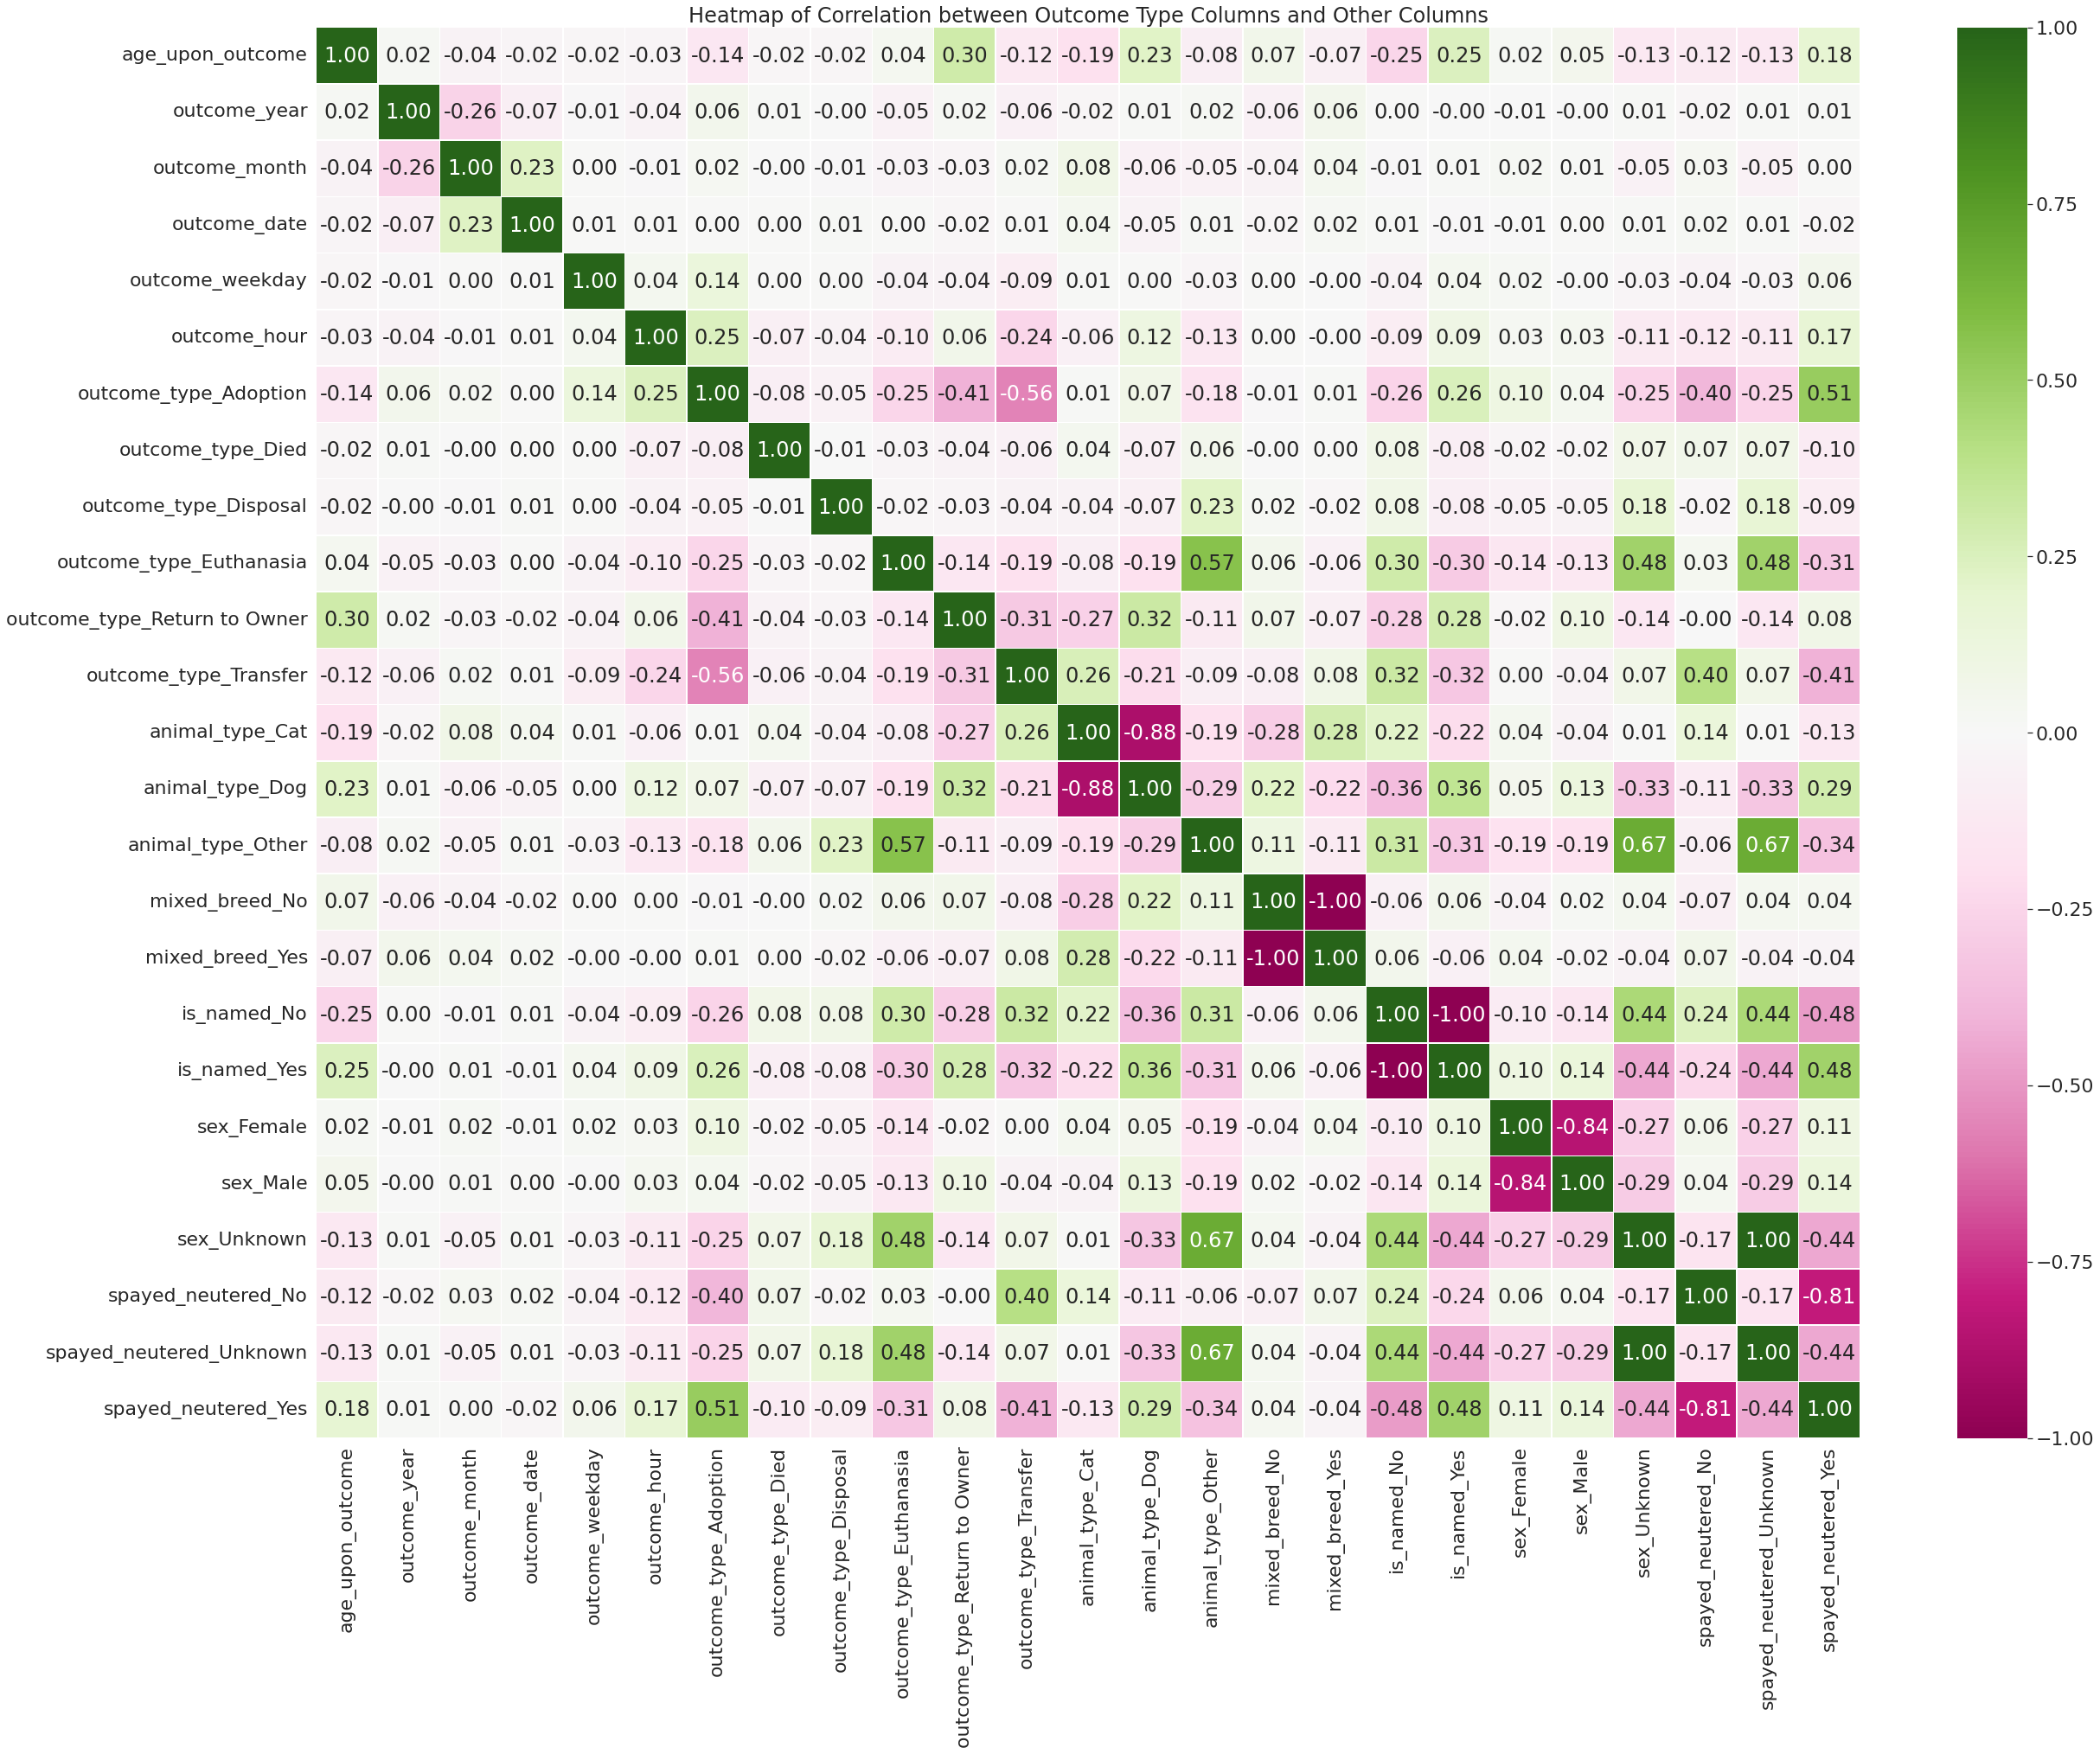

In [52]:
# Computing the correlation matrix
dtf_corr = dtf_encoded.corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(40,30))
sns.set(font_scale=2)
sns.heatmap(dtf_corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap="PiYG", cbar=True, linewidths=0.5)
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.show()

---------------We can see that columns like 'outcome_date' or 'outcome_month' have little impact on the target feature ('outcome_type'), and may not add new insights predicting it.

Comparing to 'outcome_subtype' column:

In [53]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'outcome_subtype']

# Encoding columns using one-hot encoding
dtf_encoded_outcome = pd.get_dummies(dtf, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns and outcome subtype columns
outcome_type_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_type' in col]
outcome_subtype_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_subtype' in col]

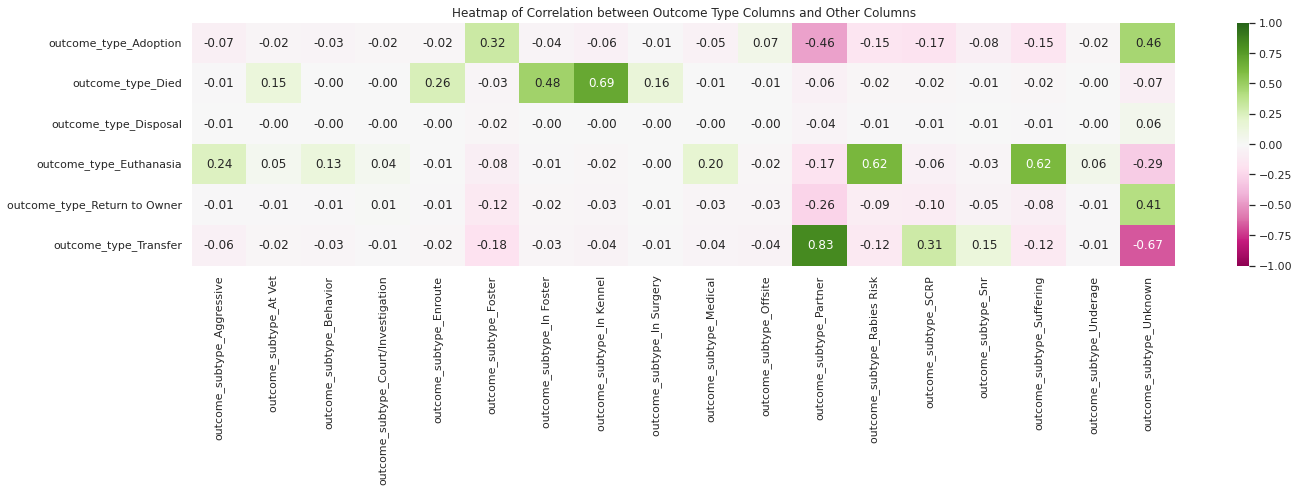

In [54]:
# Computing the correlation matrix
dtf_corr = dtf_encoded_outcome[outcome_type_columns + outcome_subtype_columns].corr(method="pearson")

# Plotting the heatmap
sns.set(font_scale=1)
plt.subplots(figsize=(20, 7))
sns.heatmap(dtf_corr.loc[outcome_type_columns, outcome_subtype_columns], vmin=-1, vmax=1, annot=True, cmap='PiYG',
        fmt=".2f")
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.tight_layout()
plt.show()

--------We can see that 'outcome_subtype_Barn' have 0 correlation to all outcome types. This is a column that we might delete...

***

## Improved ML Model

### Training the model and predicting

In [55]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [56]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'mixed_breed', 'is_named', 'outcome_subtype', 'outcome_type', 'sex',
                    'spayed_neutered']

# Columns for feature hashing
columns_for_feature_hashing = ['breed', 'color1', 'color2']

In [57]:
# One-hot encoding
encoded_one_hot = pd.get_dummies(dtf_model[columns_for_one_hot])

--------------takes 1.5 minutes. Add a skip option.

In [58]:
# Feature hashing
# Initialize an empty DataFrame for hashed features
hashed_features = pd.DataFrame(index=dtf_model.index)

n_features_breed = 200
n_features_color = 50

# Feature hashing for 'breed' column
hasher_breed = FeatureHasher(n_features=n_features_breed, input_type='string')

# Feature hashing for 'color1' column
hasher_color1 = FeatureHasher(n_features=n_features_color, input_type='string')

# Feature hashing for 'color2' column
hasher_color2 = FeatureHasher(n_features=n_features_color, input_type='string')

hashing_map = {
    'breed': (hasher_breed, n_features_breed),
    'color1': (hasher_color1, n_features_color),
    'color2': (hasher_color2, n_features_color)
}

for column, pair in hashing_map.items():
    hasher, n = pair[0], pair[1]
    hashed_column = hasher.fit_transform(dtf_model[column])
    hashed_column_df = pd.DataFrame(hashed_column.toarray(), columns=[f"{column}_hash_{i}" for i in range(n)])
    hashed_features = pd.concat([hashed_features, hashed_column_df], axis=1)

In [59]:
# Concatenate the encoded data
encoded_data = pd.concat([encoded_one_hot, hashed_features,
                        dtf_model.drop(columns_for_one_hot + columns_for_feature_hashing, axis=1)], axis=1)

# Drop rows with missing values from the encoded_data DataFrame
encoded_data = encoded_data.dropna()

In [65]:
# # Getting the column names after one-hot encoding
# columns_names = encoded_data.columns

# # Converting the resulting DataFrame to a NumPy array
# encoded_model_array = np.array(encoded_data)

In [ ]:
def get_model(model_name):
    if model_name == 'LogisticRegression':
        return LogisticRegression()
    elif model_name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample',
                    bootstrap=True, oob_score=True)
    elif model_name == 'AdaBoostClassifier':
        return AdaBoostClassifier(n_estimators=250)

In [60]:
# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

In [63]:
# Initialize lists to store accuracy scores
validation_accuracies = []
test_accuracies = []

<font color='#f542b0'>---------------takes 4 minutes. Add a skip option.</font>

In [64]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)
    print(f"Accuracy for {outcome_column}: {accuracy}")

Accuracy for outcome_type_Adoption: 0.8356929955290611
Accuracy for outcome_type_Died: 0.9927968206656731
Accuracy for outcome_type_Disposal: 0.9949701937406855
Accuracy for outcome_type_Euthanasia: 0.9658469945355191
Accuracy for outcome_type_Return to Owner: 0.8548186785891704
Accuracy for outcome_type_Transfer: 0.9621212121212122


In [65]:
# Calculate average test accuracy
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")

Average Test Accuracy: 0.9343744825302203


In [ ]:
# Initialize lists to store accuracy scores
validation_accuracies = []
test_accuracies = []

<font color='#f542b0'>---------------takes 3 minutes. Add a skip option.</font>

In [66]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Further split the training data into training and validation sets
    # (0.25 x 0.8 = 0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(X_val)
    
    # Evaluate the model on validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for {outcome_column}: {val_accuracy}")
    
    # Make predictions on test set
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for {outcome_column}: {test_accuracy}\n")

Validation Accuracy for outcome_type_Adoption: 0.8229011425732737
Test Accuracy for outcome_type_Adoption: 0.8243914555389965

Validation Accuracy for outcome_type_Died: 0.995404868355688
Test Accuracy for outcome_type_Died: 0.995404868355688

Validation Accuracy for outcome_type_Disposal: 0.9965226030799801
Test Accuracy for outcome_type_Disposal: 0.9955290611028316

Validation Accuracy for outcome_type_Euthanasia: 0.9633631395926477
Test Accuracy for outcome_type_Euthanasia: 0.962183308494784

Validation Accuracy for outcome_type_Return to Owner: 0.8550670640834576
Test Accuracy for outcome_type_Return to Owner: 0.8550049677098858

Validation Accuracy for outcome_type_Transfer: 0.9533656234475907
Test Accuracy for outcome_type_Transfer: 0.9513785394932935



In [67]:
# Calculate average validation accuracy
avg_val_accuracy = sum(validation_accuracies) / len(validation_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Calculate average test accuracy
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")

Average Validation Accuracy: 0.9311040735221064
Average Test Accuracy: 0.9325115913230665


In [72]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

In [73]:
# Initialize lists to store accuracy scores
validation_accuracies = []
test_accuracies = []

<font color='#f542b0'>---------------takes 8 minutes. Add a skip option.</font>

In [74]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]
    
    # Split the data into training, validation, and testing sets
    # (0.25 x 0.8 = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Scale the features in the training the datasets X_train, X_val and X_test
    x_train_scaled = scaler.fit_transform(X_train)
    x_val_scaled = scaler.transform(X_val)
    x_test_scaled = scaler.transform(X_test)

    # Initialize the model
    model = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', bootstrap=True,
                            oob_score=True)
    
    # Train the model
    model.fit(x_train_scaled, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(x_val_scaled)
    
    # Evaluate the model on validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for {outcome_column}: {val_accuracy}")
    
    # Make predictions on test set
    y_test_pred = model.predict(x_test_scaled)
    
    # Evaluate the model on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for {outcome_column}: {test_accuracy}\n")

Validation Accuracy for outcome_type_Adoption: 0.860966219572777
Test Accuracy for outcome_type_Adoption: 0.8610283159463488

Validation Accuracy for outcome_type_Died: 0.9967088922006955
Test Accuracy for outcome_type_Died: 0.9967088922006955

Validation Accuracy for outcome_type_Disposal: 0.9975161450571287
Test Accuracy for outcome_type_Disposal: 0.9958395429706905

Validation Accuracy for outcome_type_Euthanasia: 0.9906234475906607
Test Accuracy for outcome_type_Euthanasia: 0.991679085941381

Validation Accuracy for outcome_type_Return to Owner: 0.8639468455042225
Test Accuracy for outcome_type_Return to Owner: 0.863822652757079

Validation Accuracy for outcome_type_Transfer: 0.9804396423248882
Test Accuracy for outcome_type_Transfer: 0.9793219076005961



In [75]:
# Calculate average validation accuracy
avg_val_accuracy = sum(validation_accuracies) / len(validation_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Calculate average test accuracy
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")

Average Validation Accuracy: 0.9483668653750622
Average Test Accuracy: 0.9480667329027984


In [76]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

In [77]:
# Initialize lists to store accuracy scores
validation_accuracies = []
test_accuracies = []

<font color='#f542b0'>---------------takes _ minutes. Add a skip option.</font>

In [80]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]
    
    # Split the data into training, validation, and testing sets
    # (0.25 x 0.8 = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Scale the features in the training the datasets X_train, X_val and X_test
    x_train_scaled = scaler.fit_transform(X_train)
    x_val_scaled = scaler.transform(X_val)
    x_test_scaled = scaler.transform(X_test)
    
    # Initialize the model
    model = AdaBoostClassifier(n_estimators=250)
    
    # Train the model
    model.fit(x_train_scaled, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(x_val_scaled)
    
    # Evaluate the model on validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for {outcome_column}: {val_accuracy}")
    
    # Make predictions on test set
    y_test_pred = model.predict(x_test_scaled)
    
    # Evaluate the model on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for {outcome_column}: {test_accuracy}\n")

Validation Accuracy for outcome_type_Adoption: 0.8651887729756582
Test Accuracy for outcome_type_Adoption: 0.8656234475906607



In [ ]:
# Calculate average validation accuracy
avg_val_accuracy = sum(validation_accuracies) / len(validation_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Calculate average test accuracy
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")